In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_parquet('clean_data.parquet')

## Understanding the Dataset

The dataset amalgamates information from various sources, as detailed in the `table_creation.ipynb` notebook. It encompasses hourly data on NO2 levels recorded at different stations in Madrid throughout the year 2018. Each row represents data from a specific hour and station.


### Variables Description

- **PROVINCIA, MUNICIPIO, ESTACION, PUNTO_MUESTREO:** These are standard codes for geographical locations. `PUNTO_MUESTREO` is a composite identifier combining the rest of the location features.

- **NO2_level:** This variable denotes the recorded levels of nitrogen dioxide (NO2) in the air. It serves as a key indicator of air quality.

- **FECHA:** Represents the timestamp of the data, providing information on the date and time of each recorded observation.

- **temp:** Indicates the temperature at the respective hour (recorded in Madrid).

- **area, name, address, altitude, type, longitude, latitude:** These features provide additional information about the station, including its geographical attributes and categorization.



#### STRUCTURE:
1. First we will check each of the tables we will be working with in order to understand deeply the information. Then we can start thinking about creating hypothesis.

2. We now look for null values, weird outliers and make sure our data is OK. Then we make decisions and justify why we impute values or delete certain features/rows.

3. Once cleaned, we join tables and create new features.

4. We test the hypothesis we created.


### Inventory
Info about each item id

In [3]:
df.head()

,PROVINCIA,MUNICIPIO,ESTACION,PUNTO_MUESTREO,NO2_level,FECHA,temp,area,name,address,altitude,type,longitude,latitude
0,28,79,4,28079004,15.0,2018-01-01 00:30:00,7.3,centro,Pza. de España,Plaza de España,635,UT,-3.712247,40.423853
1,28,79,4,28079004,13.0,2018-01-02 00:30:00,9.1,centro,Pza. de España,Plaza de España,635,UT,-3.712247,40.423853
2,28,79,4,28079004,35.0,2018-01-03 00:30:00,7.5,centro,Pza. de España,Plaza de España,635,UT,-3.712247,40.423853
3,28,79,4,28079004,35.0,2018-01-04 00:30:00,8.1,centro,Pza. de España,Plaza de España,635,UT,-3.712247,40.423853
4,28,79,4,28079004,24.0,2018-01-05 00:30:00,9.7,centro,Pza. de España,Plaza de España,635,UT,-3.712247,40.423853


In [4]:
df.nunique()

PROVINCIA            1
MUNICIPIO            1
ESTACION            24
PUNTO_MUESTREO      24
NO2_level          252
FECHA             8760
temp               438
area                 5
name                24
address             24
altitude            23
type                 3
longitude           24
latitude            24
dtype: int64

Since we already know we are working with data from Madrid, we can drop the PROVINCIA, MUNICIPIO AND PUNTO_MUESTREO features

In [5]:
df = df.drop(columns=['PROVINCIA', 'MUNICIPIO', 'PUNTO_MUESTREO'], axis = 1)

In [6]:
df.head()

,ESTACION,NO2_level,FECHA,temp,area,name,address,altitude,type,longitude,latitude
0,4,15.0,2018-01-01 00:30:00,7.3,centro,Pza. de España,Plaza de España,635,UT,-3.712247,40.423853
1,4,13.0,2018-01-02 00:30:00,9.1,centro,Pza. de España,Plaza de España,635,UT,-3.712247,40.423853
2,4,35.0,2018-01-03 00:30:00,7.5,centro,Pza. de España,Plaza de España,635,UT,-3.712247,40.423853
3,4,35.0,2018-01-04 00:30:00,8.1,centro,Pza. de España,Plaza de España,635,UT,-3.712247,40.423853
4,4,24.0,2018-01-05 00:30:00,9.7,centro,Pza. de España,Plaza de España,635,UT,-3.712247,40.423853


And I'm guessing ESTACION contains a unique identifier for each station name / address, so we can keep only one of those without losing info

In [7]:
df.groupby('ESTACION')[['name', 'address']].nunique()

,name,address
ESTACION,,
4,1,1
8,1,1
11,1,1
16,1,1
17,1,1
18,1,1
24,1,1
27,1,1
35,1,1


In [8]:
# We will just keep the name
df = df.drop(columns=['ESTACION', 'address'], axis = 1)

In [9]:
df.head()

,NO2_level,FECHA,temp,area,name,altitude,type,longitude,latitude
0,15.0,2018-01-01 00:30:00,7.3,centro,Pza. de España,635,UT,-3.712247,40.423853
1,13.0,2018-01-02 00:30:00,9.1,centro,Pza. de España,635,UT,-3.712247,40.423853
2,35.0,2018-01-03 00:30:00,7.5,centro,Pza. de España,635,UT,-3.712247,40.423853
3,35.0,2018-01-04 00:30:00,8.1,centro,Pza. de España,635,UT,-3.712247,40.423853
4,24.0,2018-01-05 00:30:00,9.7,centro,Pza. de España,635,UT,-3.712247,40.423853


### Handling missing data

In [10]:
df.isna().sum()

NO2_level    324
FECHA          0
temp           0
area           0
name           0
altitude       0
type           0
longitude      0
latitude       0
dtype: int64

Let's explore those missing values and their distribution

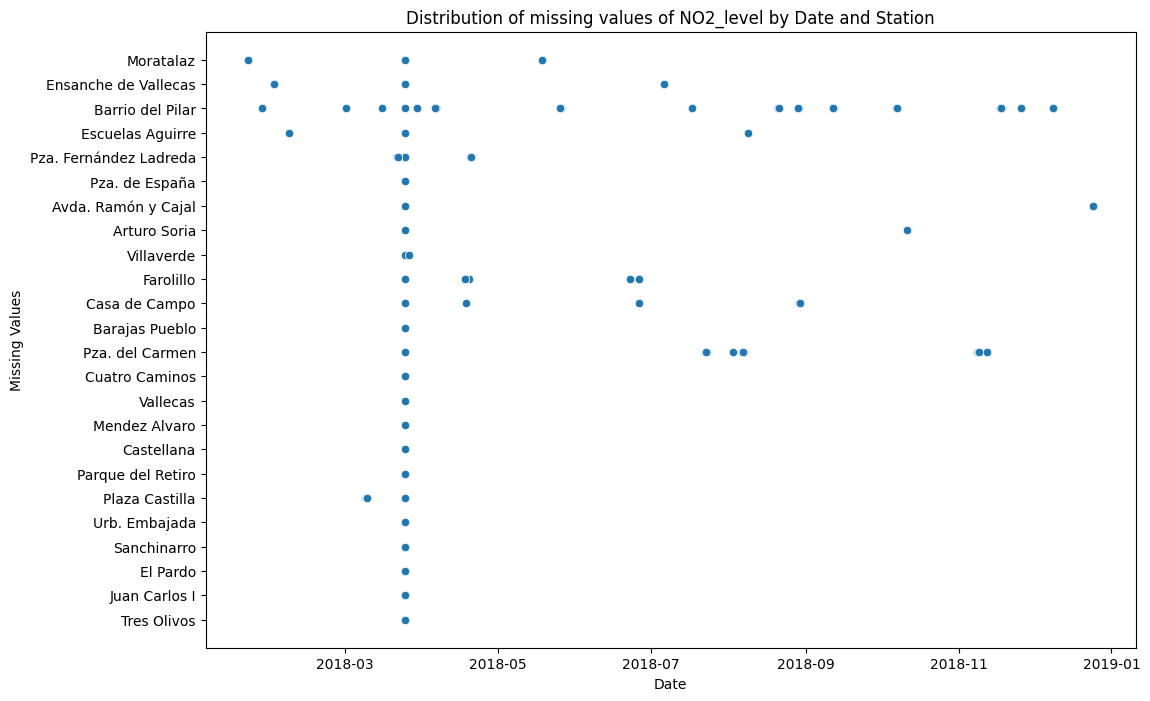

In [11]:
# Create new column indicating if 'NO2_level' is NaN
df['missing_values'] = df['NO2_level'].isna()

missing_values_df = df[df['missing_values']]

# Create scatterplot
plt.figure(figsize=(12, 8))
sns.scatterplot(x='FECHA', y='name', data=missing_values_df)
plt.title('Distribution of missing values of NO2_level by Date and Station')
plt.xlabel('Date')
plt.ylabel('Missing Values')
plt.show()

It looks that we have one time where no station got any data, so we should drop that specific timestamp. Other than that, it looks like our missing values are randomly distributed and are only a few points, so for those, we will make a time-based imputation

In [12]:
df.groupby(df['FECHA'].dt.date)['missing_values'].sum().idxmax()


datetime.date(2018, 3, 25)

In [13]:
df.groupby(df['FECHA'].dt.date)['missing_values'].sum().max()

24

What happened the 25th of March? Ha! Our time zone change!

In [14]:
df[(df['FECHA'].dt.date == pd.to_datetime('2018-03-25').date()) & (df['missing_values'] == True)]

,NO2_level,FECHA,temp,area,name,altitude,type,longitude,latitude,missing_values
35496,NaN,2018-03-25 02:30:00,7.0,centro,Pza. de España,635,UT,-3.712247,40.423853,True
35527,NaN,2018-03-25 02:30:00,7.0,centro,Escuelas Aguirre,670,UT,-3.682319,40.421564,True
35558,NaN,2018-03-25 02:30:00,7.0,centro,Avda. Ramón y Cajal,708,UT,-3.677356,40.451475,True
35589,NaN,2018-03-25 02:30:00,7.0,noreste,Arturo Soria,693,UF,-3.639233,40.440047,True
35620,NaN,2018-03-25 02:30:00,7.0,suroeste,Villaverde,604,UF,-3.713322,40.347139,True
35651,NaN,2018-03-25 02:30:00,7.0,suroeste,Farolillo,630,UF,-3.731853,40.394781,True
35682,NaN,2018-03-25 02:30:00,7.0,noroeste,Casa de Campo,642,S,-3.747347,40.419356,True
35713,NaN,2018-03-25 02:30:00,7.0,noreste,Barajas Pueblo,621,UF,-3.580031,40.476928,True
35744,NaN,2018-03-25 02:30:00,7.0,centro,Pza. del Carmen,659,UF,-3.703172,40.419208,True
35775,NaN,2018-03-25 02:30:00,7.0,sureste,Moratalaz,685,UT,-3.645306,40.407947,True


We have a data gap for all our stations at 2:00 am, coinciding with the time when we adjust our timezone. So we drop this hour.

In [15]:
df = df[df['FECHA'] != '2018-03-25 02:30:00']

Let's check again

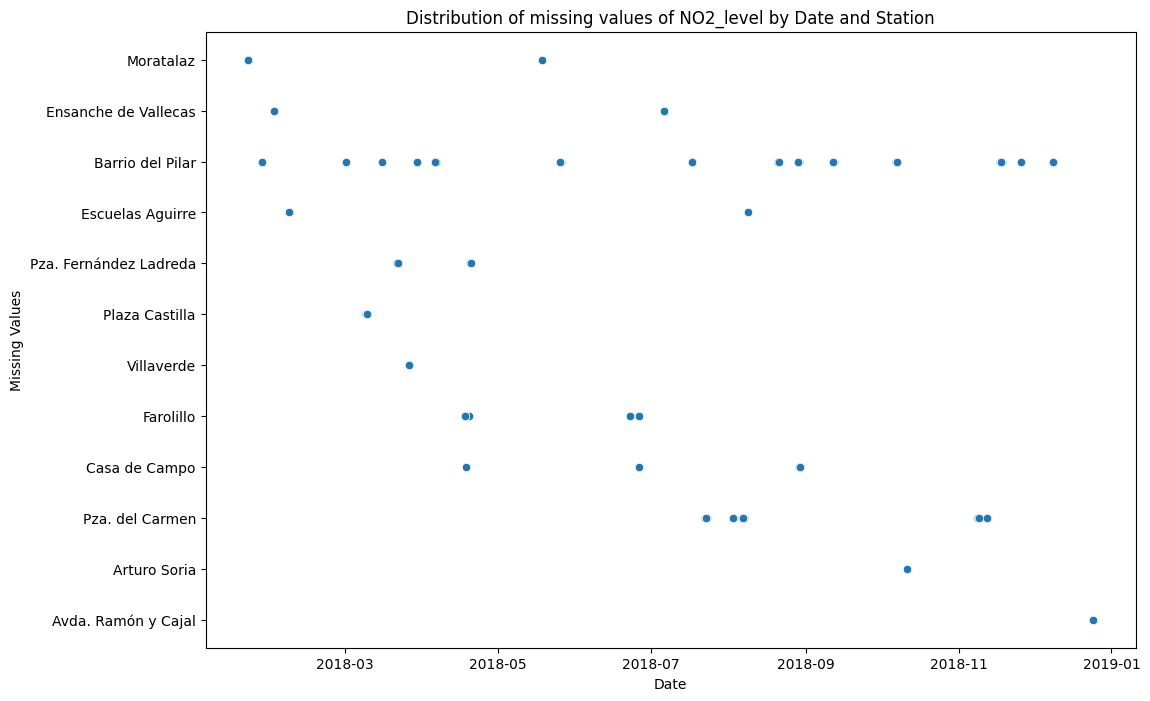

In [16]:
# Create new column indicating if 'NO2_level' is NaN
df['missing_values'] = df['NO2_level'].isna()

missing_values_df = df[df['missing_values']]

# Create scatterplot
plt.figure(figsize=(12, 8))
sns.scatterplot(x='FECHA', y='name', data=missing_values_df)
plt.title('Distribution of missing values of NO2_level by Date and Station')
plt.xlabel('Date')
plt.ylabel('Missing Values')
plt.show()

We will imput those missing values based on the daily mean of all stations

In [17]:
daily_mean = df.groupby(df['FECHA'].dt.date)['NO2_level'].mean()
df['NO2_level'] = df['NO2_level'].fillna(df['FECHA'].dt.date.map(daily_mean))

In [18]:
df = df.drop(columns = 'missing_values', axis = 1)

In [19]:
df.isna().sum()

NO2_level    0
FECHA        0
temp         0
area         0
name         0
altitude     0
type         0
longitude    0
latitude     0
dtype: int64

### Exploration and Visualization of Madrid Pollution Data

1. **Daily/Monthly Pollution Evolution:**
   - Create line charts depicting the daily and monthly evolution of NO2 levels across different stations.
   - Calculate daily and monthly averages to smooth out daily variability.

2. **Animated Heatmaps:**
   - Use visualization libraries like Folium or Plotly to craft animated heatmaps illustrating hourly/daily variation in pollution across different areas in Madrid.

3. **Analysis of Extraordinary Situations:**
   - Identify and analyze days with traffic restrictions or special events in Madrid. Compare pollution levels on these days with normal days.
   - Evaluate the effectiveness of specific measures implemented to reduce pollution.

4. **Data Exploration:**
   - Conduct exploratory data analysis to identify seasonal patterns in NO2 levels.
   - Investigate the correlation between temperature (column 'temp') and pollution levels.

5. **Comparison Between Stations:**
   - Compare NO2 levels between different stations to identify more affected areas.
   - Create scatter plots to visualize the relationship between altitude and pollution levels.

6. **Temporal Trend Visualization:**
   - Use line or bar charts to showcase temporal trends in pollution throughout the year.
   - Examine hourly and daily variability in pollution levels.

7. **Analysis of Environmental Factors:**
   - Investigate how environmental factors such as temperature and altitude impact pollution levels.
   - Employ regression techniques to model the relationship between different variables.


1. **Daily/Monthly Pollution Evolution:**
   - Create line charts depicting the daily and monthly evolution of NO2 levels across different stations.
   - Calculate daily and monthly averages to smooth out daily variability.

In [20]:
# Daily averages
daily_avg = df.groupby(df['FECHA'].dt.date)['NO2_level'].mean()

# Monthly averages
monthly_avg = df.resample('ME', on='FECHA')['NO2_level'].mean()


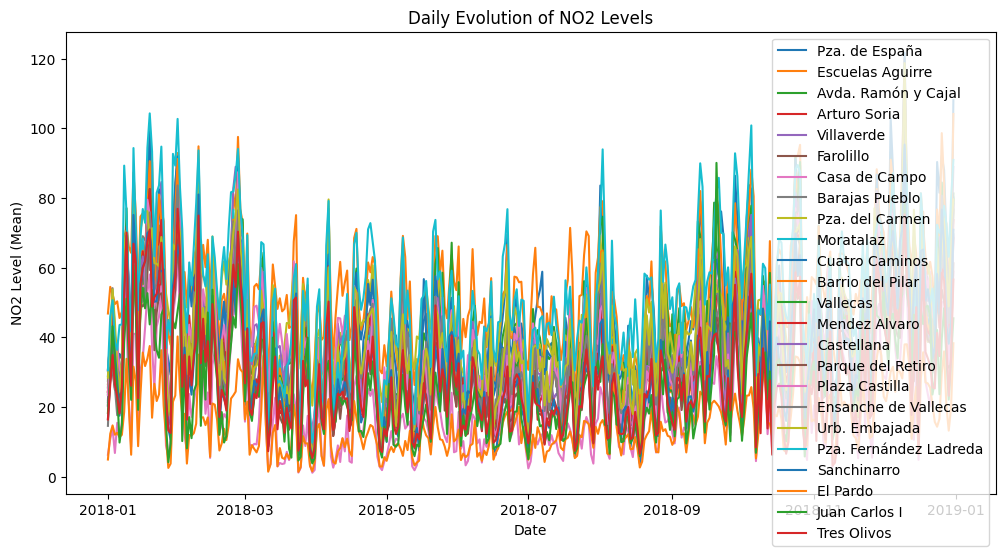

In [21]:
plt.figure(figsize=(12, 6))
for station in df['name'].unique():
    station_data = df[df['name'] == station].groupby(df['FECHA'].dt.date)['NO2_level'].mean()
    plt.plot(daily_avg.index, station_data.reindex(daily_avg.index), label=station)

plt.title('Daily Evolution of NO2 Levels')
plt.xlabel('Date')
plt.ylabel('NO2 Level (Mean)')
plt.legend()
plt.show()


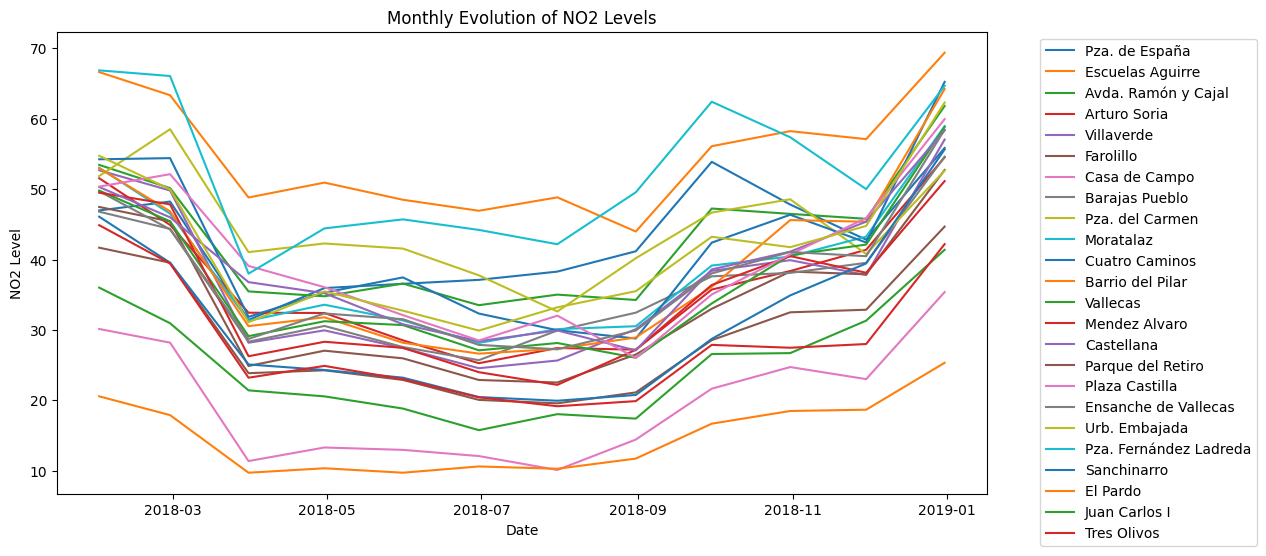

In [22]:
# Line chart for monthly averages
plt.figure(figsize=(12, 6))
for station in df['name'].unique():
    plt.plot(monthly_avg.index, df[df['name'] == station].resample('ME', on='FECHA')['NO2_level'].mean(), label=station)

plt.title('Monthly Evolution of NO2 Levels')
plt.xlabel('Date')
plt.ylabel('NO2 Level')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


2. **Animated Heatmaps:**
   - Use visualization libraries like Folium or Plotly to craft animated heatmaps illustrating hourly/daily variation in pollution across different areas in Madrid.

In [23]:
import folium
from folium.plugins import HeatMap

In [24]:
# Crea un mapa centrado en Madrid
m = folium.Map(location=[40.4168, -3.7038], zoom_start=11)

# Agrega datos de latitud, longitud y valor de NO2 para cada punto
heat_data = [[lat, lon, value] for lat, lon, value in zip(df['latitude'], df['longitude'], df['NO2_level'])]

# Agrega el mapa de calor
HeatMap(heat_data).add_to(m)

# Guarda el mapa como un archivo HTML
m.save('heatmap_folium.html')

In [25]:
import plotly.express as px

In [29]:
# Crea un mapa centrado en Madrid
fig = px.scatter_geo(df, 
                     lat='latitude', 
                     lon='longitude', 
                     color='NO2_level',
                     animation_frame='FECHA',  
                     projection='mercator')

# Ajusta el centro y el zoom para enfocar en Madrid
fig.update_geos(center=dict(lat=40.4168, lon=-3.7038),  # Coordenadas de Madrid
                projection_scale=70)  # Ajusta el nivel de zoom según sea necesario

# Muestra el mapa en el notebook o guarda como un archivo HTML
# fig.show()
# O
fig.write_html('heatmap_plotly.html')



3. **Analysis of Extraordinary Situations:**
   - Identify and analyze days with traffic restrictions or special events in Madrid. Compare pollution levels on these days with normal days.
   - Evaluate the effectiveness of specific measures implemented to reduce pollution.


Let's think for special days in Madrid...
And possible special measures for reducing pollution taken by the government


4. **Data Exploration:**
   - Conduct exploratory data analysis to identify seasonal patterns in NO2 levels.
   - Investigate the correlation between temperature (column 'temp') and pollution levels.


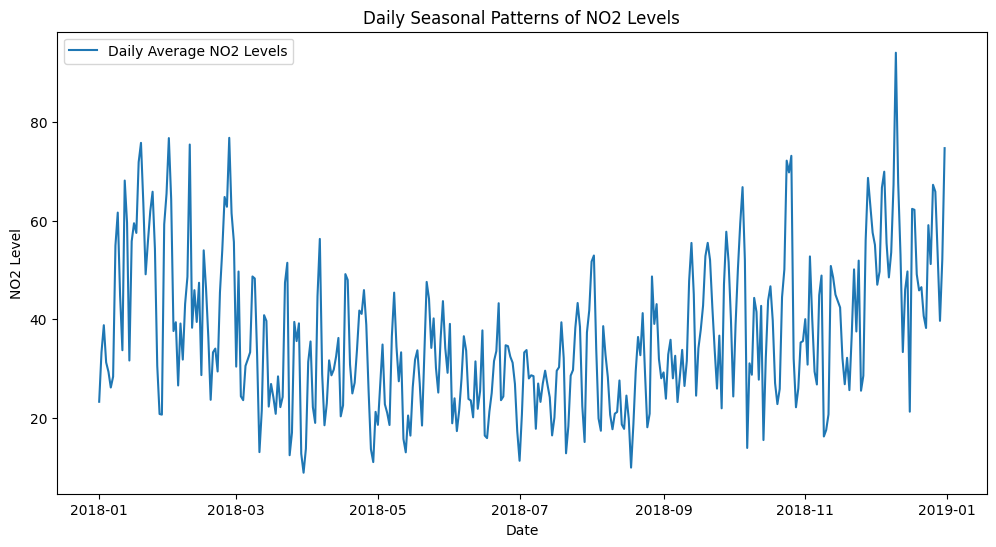

In [30]:
df['date'] = df['FECHA'].dt.date

# Plotting daily average NO2 levels
daily_avg = df.groupby('date')['NO2_level'].mean()
plt.figure(figsize=(12, 6))
plt.plot(daily_avg.index, daily_avg, label='Daily Average NO2 Levels')
plt.title('Daily Seasonal Patterns of NO2 Levels')
plt.xlabel('Date')
plt.ylabel('NO2 Level')
plt.legend()
plt.show()

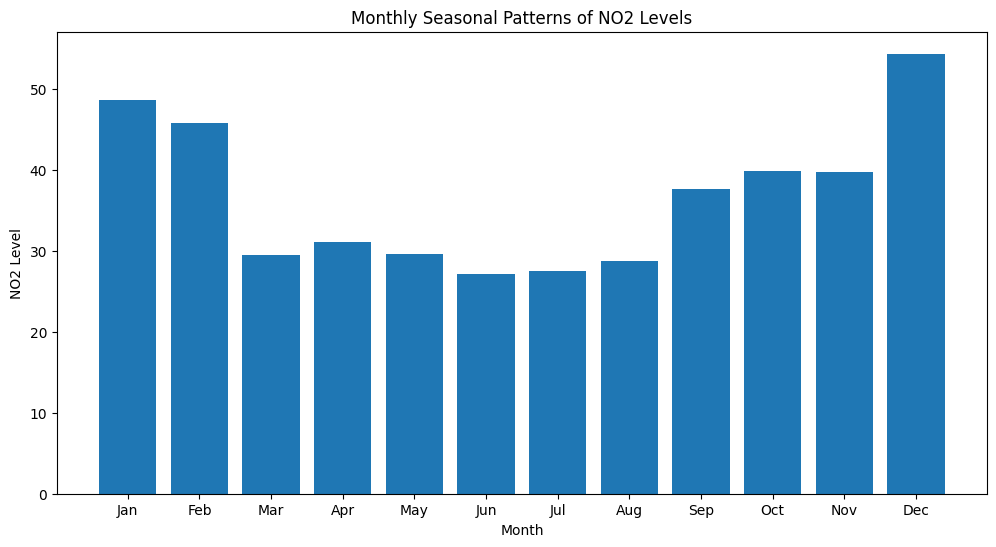

In [31]:
# Extract month information for analysis
df['month'] = df['FECHA'].dt.month

# Plotting monthly average NO2 levels
monthly_avg = df.groupby('month')['NO2_level'].mean()
plt.figure(figsize=(12, 6))
plt.bar(monthly_avg.index, monthly_avg, tick_label=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.title('Monthly Seasonal Patterns of NO2 Levels')
plt.xlabel('Month')
plt.ylabel('NO2 Level')
plt.show()

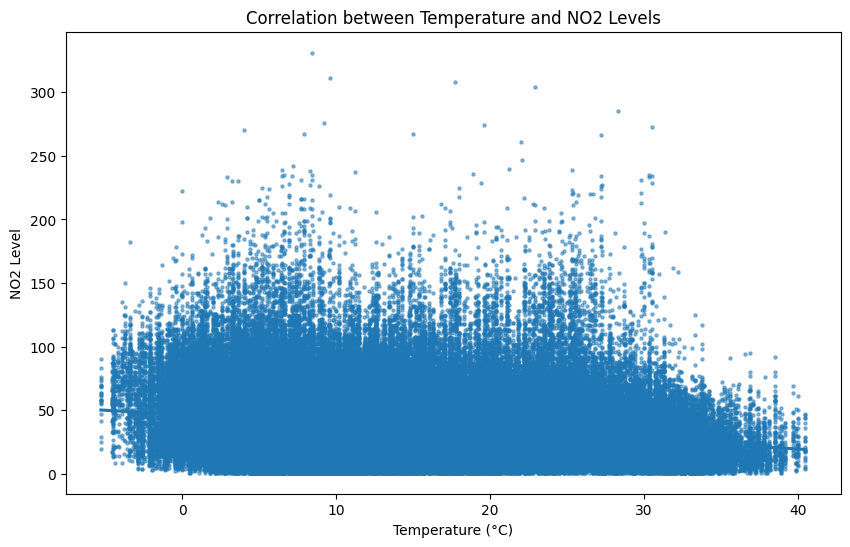

In [32]:
# Scatter plot with regression line
plt.figure(figsize=(10, 6))
sns.regplot(x='temp', y='NO2_level', data=df, scatter_kws={'s': 5, 'alpha': 0.5})
plt.title('Correlation between Temperature and NO2 Levels')
plt.xlabel('Temperature (°C)')
plt.ylabel('NO2 Level')
plt.show()

#### Differences between Day and night:

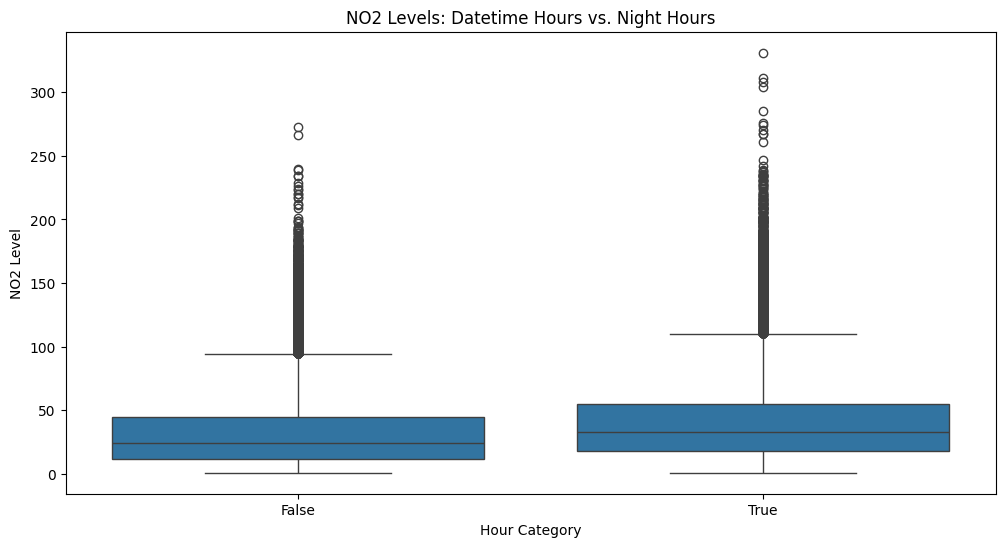

In [35]:
# Extract hour information for analysis
df['hour'] = df['FECHA'].dt.hour

# Define peak hours (adjust these as needed)
day_hours = range(7, 22)  # Example: 7 AM to 9 PM

# Create a new column to identify peak hours
df['is_daytime'] = df['hour'].isin(day_hours)

# Plotting NO2 levels for peak and normal hours
plt.figure(figsize=(12, 6))
sns.boxplot(x='is_daytime', y='NO2_level', data=df)
plt.title('NO2 Levels: Datetime Hours vs. Night Hours')
plt.xlabel('Hour Category')
plt.ylabel('NO2 Level')
plt.show()

#### Differences between Weekdays and Weekends:

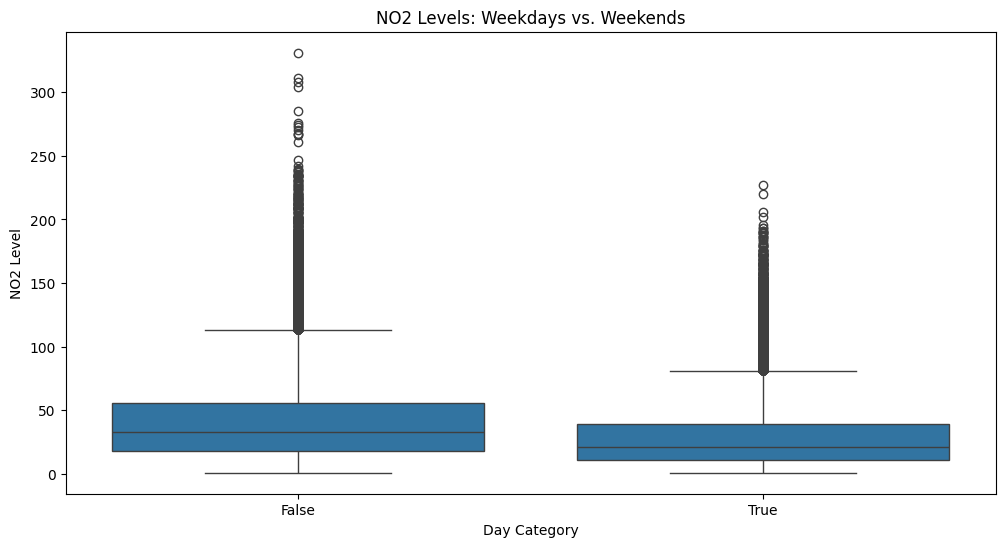

In [34]:
# Extract weekday information for analysis (Monday is 0, Sunday is 6)
df['weekday'] = df['FECHA'].dt.weekday

# Create a new column to identify weekends
df['is_weekend'] = df['weekday'].isin([5, 6])  # Assuming Saturday and Sunday are weekends

# Plotting NO2 levels for weekdays and weekends
plt.figure(figsize=(12, 6))
sns.boxplot(x='is_weekend', y='NO2_level', data=df)
plt.title('NO2 Levels: Weekdays vs. Weekends')
plt.xlabel('Day Category')
plt.ylabel('NO2 Level')
plt.show()



5. **Comparison Between Stations:**
   - Compare NO2 levels between different stations to identify more affected areas.
   - Create scatter plots to visualize the relationship between altitude and pollution levels.



6. **Temporal Trend Visualization:**
   - Use line or bar charts to showcase temporal trends in pollution throughout the year.
   - Examine hourly and daily variability in pollution levels.



7. **Analysis of Environmental Factors:**
   - Investigate how environmental factors such as temperature and altitude impact pollution levels.
   - Employ regression techniques to model the relationship between different variables.